In [1]:
import pandas as pd
from nilearn.plotting import plot_img
from nilearn.image import load_img, index_img, new_img_like

/home/javi/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


### Average distance between pipelines per region

In [2]:
from scipy.io import loadmat
from glob import glob

region_names = sorted([x.split("/")[-1] for x in glob("clustering/roi_68/*")])

sim_pattern_roi_alpha=[]
for roi_name in np.sort(region_names):
    sim_pattern_roi_alpha.append(squareform(np.mean([loadmat(rec_mat)['R'] for rec_mat in glob(f"./similarity_matrices/roi_68/{roi_name}/alpha/*")],
                                              axis=0), checks=False))
sim_pattern_roi_alpha = np.array(sim_pattern_roi_alpha)

sim_pattern_roi_beta=[]
for roi_name in np.sort(region_names):
    sim_pattern_roi_beta.append(squareform(np.mean([loadmat(rec_mat)['R'] for rec_mat in glob(f"./similarity_matrices/roi_68/{roi_name}/beta/*")],
                                              axis=0), checks=False))
sim_pattern_roi_beta = np.array(sim_pattern_roi_beta)


sim_pattern_roi_theta=[]
for roi_name in np.sort(region_names):
    sim_pattern_roi_theta.append(squareform(np.mean([loadmat(rec_mat)['R'] for rec_mat in glob(f"./similarity_matrices/roi_68/{roi_name}/theta/*")],
                                              axis=0), checks=False))
sim_pattern_roi_theta = np.array(sim_pattern_roi_theta)

In [4]:
rois = pd.read_csv("data/rois.txt", header=None)
rois = pd.DataFrame({'roi':rois.loc[:,0], 'roi_index': np.arange(1,83)})

dist_alpha_68 = pd.DataFrame({'value': np.mean(1-sim_pattern_roi_alpha, axis=1),
                              'roi': np.sort(region_names)})
dist_alpha_68.roi = dist_alpha_68.roi.apply(lambda x: "ctx-" + x.split("_")[1].lower() + "h-" + x.split("_")[0].lower())
dist_alpha_68 = pd.merge(rois, dist_alpha_68, on="roi")

dist_beta_68 = pd.DataFrame({'value': np.mean(1-sim_pattern_roi_beta, axis=1),
                             'roi': np.sort(region_names)})
dist_beta_68.roi = dist_beta_68.roi.apply(lambda x: "ctx-" + x.split("_")[1].lower() + "h-" + x.split("_")[0].lower())
dist_beta_68 = pd.merge(rois, dist_beta_68, on="roi")

dist_theta_68 =  pd.DataFrame({'value': np.mean(1-sim_pattern_roi_theta, axis=1),
                             'roi': np.sort(region_names)})
dist_theta_68.roi = dist_theta_68.roi.apply(lambda x: "ctx-" + x.split("_")[1].lower() + "h-" + x.split("_")[0].lower())
dist_theta_68 = pd.merge(rois, dist_theta_68, on="roi")

### Average distance versus region volume

In [5]:
vols_lh_df = pd.melt(pd.read_csv("data/cvs_avg35_inMNI152_desikan_vols_lh.txt", sep="\t").iloc[:,1:])
vols_lh_df.variable = vols_lh_df.variable.apply(lambda x: "ctx-" + "lh-" +  x.split("_")[1].lower())

vols_rh_df = pd.melt(pd.read_csv("data/cvs_avg35_inMNI152_desikan_vols_rh.txt", sep="\t").iloc[:,1:])
vols_rh_df.variable = vols_rh_df.variable.apply(lambda x: "ctx-" + "rh-" +  x.split("_")[1].lower())

vols_df = pd.concat([vols_lh_df, vols_rh_df], axis=0)
vols_df = vols_df.rename(columns={'value': 'Volume', 'variable':'roi'})
vols_df

,roi,Volume
0,ctx-lh-bankssts,2371.0
1,ctx-lh-caudalanteriorcingulate,1493.0
2,ctx-lh-caudalmiddlefrontal,7254.0
3,ctx-lh-cuneus,4176.0
4,ctx-lh-entorhinal,2196.0
...,...,...
29,ctx-rh-supramarginal,8733.0
30,ctx-rh-frontalpole,1324.0
31,ctx-rh-temporalpole,2609.0
32,ctx-rh-transversetemporal,1109.0


In [6]:
import seaborn as sns

dist_alpha_68_vols = pd.merge(dist_alpha_68, vols_df, on="roi")
dist_alpha_68_vols["band"]="alpha"

dist_beta_68_vols = pd.merge(dist_beta_68, vols_df, on="roi")
dist_beta_68_vols["band"]="beta"

dist_theta_68_vols = pd.merge(dist_theta_68, vols_df, on="roi")
dist_theta_68_vols["band"]="theta"

dist_68_vols = pd.concat([dist_alpha_68_vols, dist_beta_68_vols, dist_theta_68_vols], axis=0)
dist_68_vols = dist_68_vols.rename(columns={'value': 'Average Distance'})

<AxesSubplot:xlabel='band', ylabel='Average Distance'>

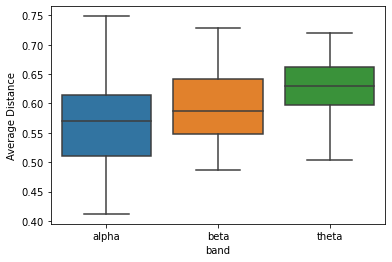

In [7]:
sns.boxplot(x="band", y="Average Distance",data=dist_68_vols)

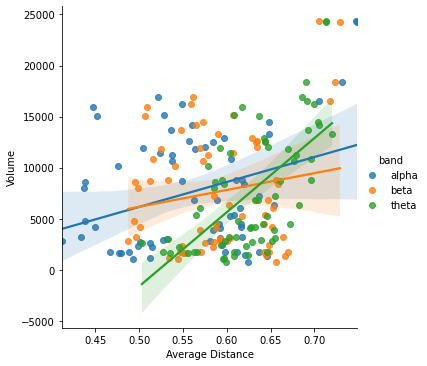

In [8]:
sns.lmplot(x='Average Distance', y='Volume', hue="band", data=dist_68_vols)

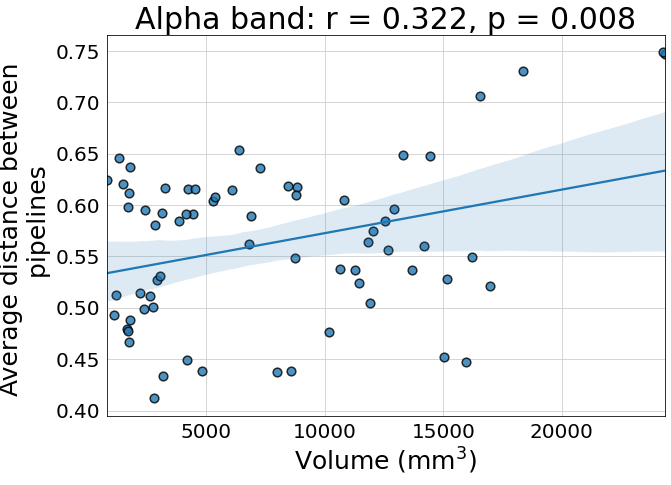

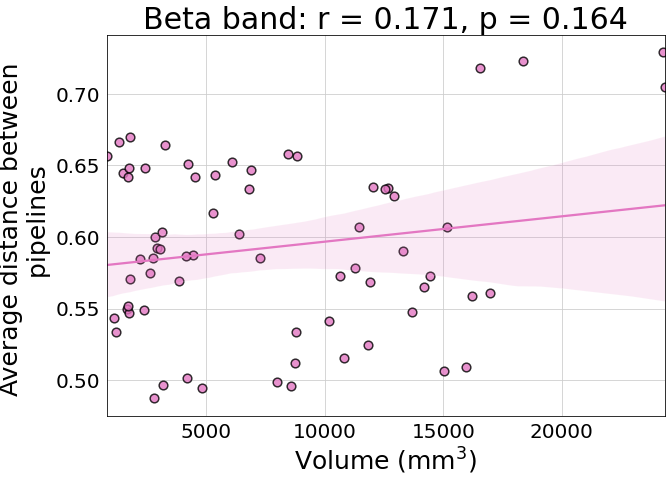

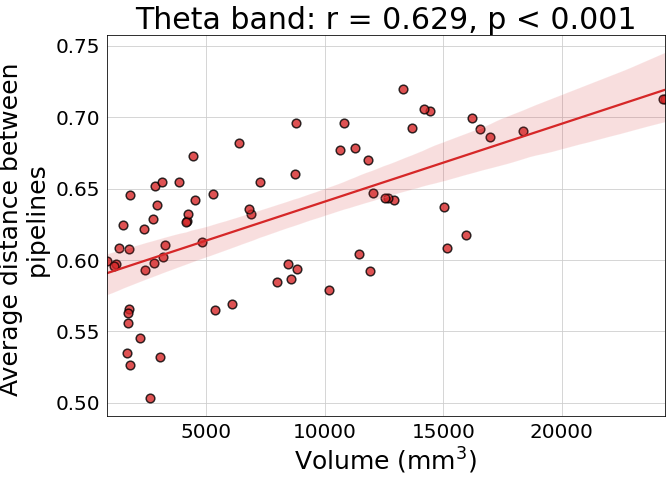

In [9]:
# Scatter plots distance vs volume
from scipy.stats import pearsonr

for band in ["alpha", "beta", "theta"]:
    
    if band=="alpha":
        color = sns.color_palette()[0]
    elif band=="beta":
        color = sns.color_palette()[6]
    else:
        color = sns.color_palette()[3]
        
    r,p = pearsonr(dist_68_vols[dist_68_vols.band==band]['Average Distance'], 
                   dist_68_vols[dist_68_vols.band==band]['Volume'])
    
    if p<0.001:
        p = "p < 0.001"
    else:
        p = f"p = {p:.3f}"
    

    with sns.axes_style("whitegrid", rc={'axes.edgecolor':'black', 'text.color': '.0'}):
        fig, ax = plt.subplots(figsize=(10, 7))
        sns.regplot(y='Average Distance', x='Volume', data=dist_68_vols[dist_68_vols.band==band], 
                ax=ax, scatter_kws={'edgecolor':'black', 'linewidth':1.5, 's':75}, marker="o", color=color)
        ax.tick_params(labelsize=20,  colors='0.')
        ax.set_ylabel("Average distance between \n pipelines", size=25, color='0.')
        ax.set_xlabel(r'Volume (${\rm mm}^3$)', size=25, color='0.')
        ax.set_title(band[0].upper() + band[1:]+ f" band: r = {r:.3f}, {p}", size=30)
        plt.savefig(f"plots/dist_vs_vols_{band}_68_v2.png")

### Map distance to desikan atlas

In [11]:
desikan = index_img(load_img("data/Desikan+wm_genetics_1mm.nii.gz"), 0)

data = np.zeros_like(desikan.get_fdata())

for _,row in dist_alpha_68.iterrows():
    data[desikan.get_fdata()==int(row.roi_index)] =  row.value
    
dist_alpha_68_img = new_img_like(desikan, data)

data = np.zeros_like(desikan.get_fdata())

for _,row in dist_beta_68.iterrows():
    data[desikan.get_fdata()==int(row.roi_index)] =  row.value
    
dist_beta_68_img = new_img_like(desikan, data)

data = np.zeros_like(desikan.get_fdata())

for _,row in dist_theta_68.iterrows():
    data[desikan.get_fdata()==int(row.roi_index)] =  row.value
    
dist_theta_68_img = new_img_like(desikan, data)

In [12]:
dist_alpha_68_img.to_filename("outputs/d_alpha_68.nii.gz")
dist_beta_68_img.to_filename("outputs/d_beta_68.nii.gz")
dist_theta_68_img.to_filename("outputs/d_theta_68.nii.gz")

In [13]:
import os
for band in ["alpha", "beta", "theta"]:
    for hemi in ["L", "R"]:
        ref_surface= f"data/Q1-Q6_R440.{hemi}.white.164k_fs_LR.surf.gii"
        cmd = f"wb_command -volume-to-surface-mapping outputs/d_{band}_68.nii.gz {ref_surface} outputs/d_{band}_{hemi}.shape.gii -enclosing"
        os.system(cmd)

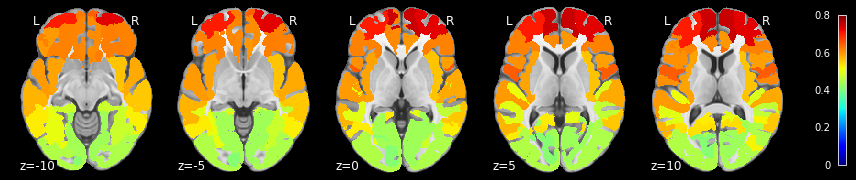

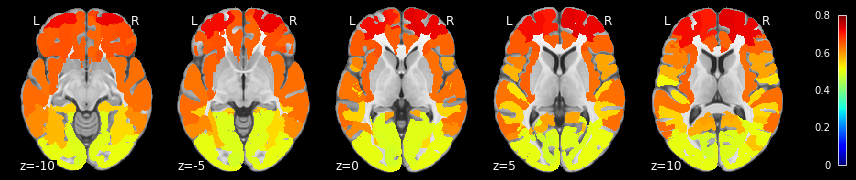

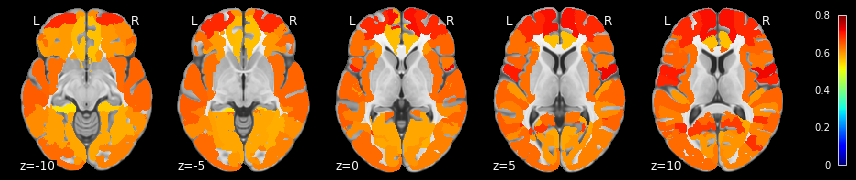

In [14]:
from nilearn.datasets import load_mni152_template

plot_img(dist_alpha_68_img, colorbar=True, vmax=0.8, vmin=0, cmap=plt.cm.jet, threshold=1e-6, 
         bg_img=load_mni152_template(resolution=1), display_mode="z",
         cut_coords=(-10, -5, 0, 5, 10), black_bg=True)
plot_img(dist_beta_68_img, colorbar=True, vmax=0.8, vmin=0, cmap=plt.cm.jet, threshold=1e-6, 
         bg_img=load_mni152_template(resolution=1), display_mode="z",
         cut_coords=(-10, -5, 0, 5, 10), black_bg=True)
plot_img(dist_theta_68_img, colorbar=True, vmax=0.8, vmin=0, cmap=plt.cm.jet, threshold=1e-6, 
         bg_img=load_mni152_template(resolution=1), display_mode="z",
         cut_coords=(-10, -5, 0, 5, 10), black_bg=True)

### Cluster regions according to their patterns in similarity between pipelines

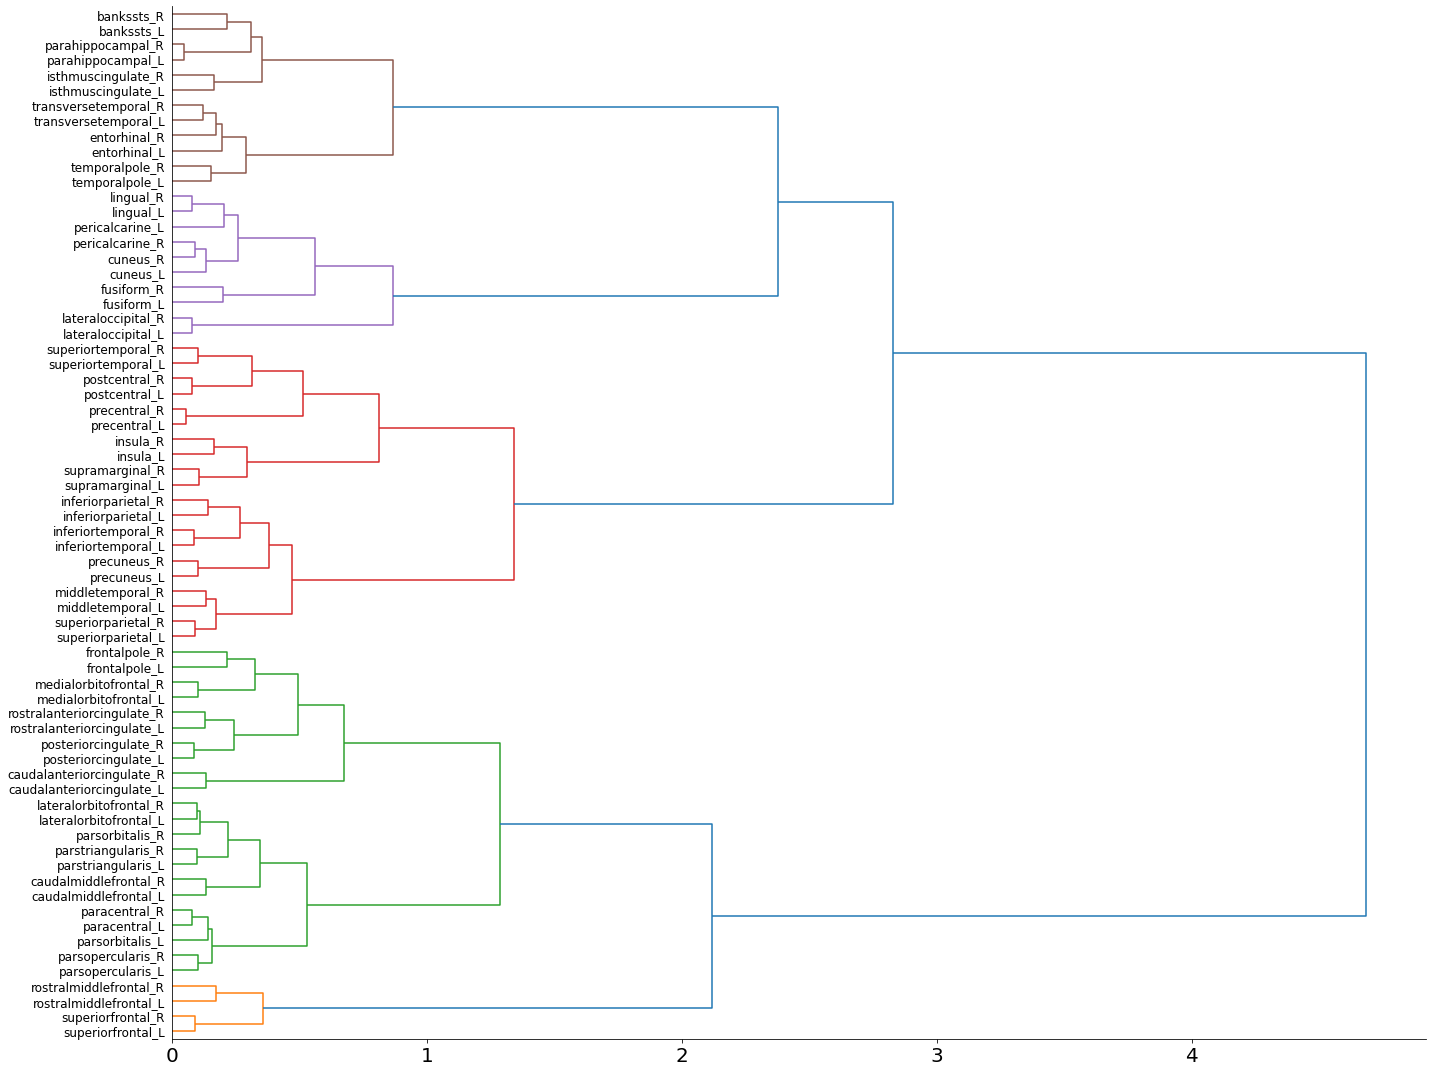

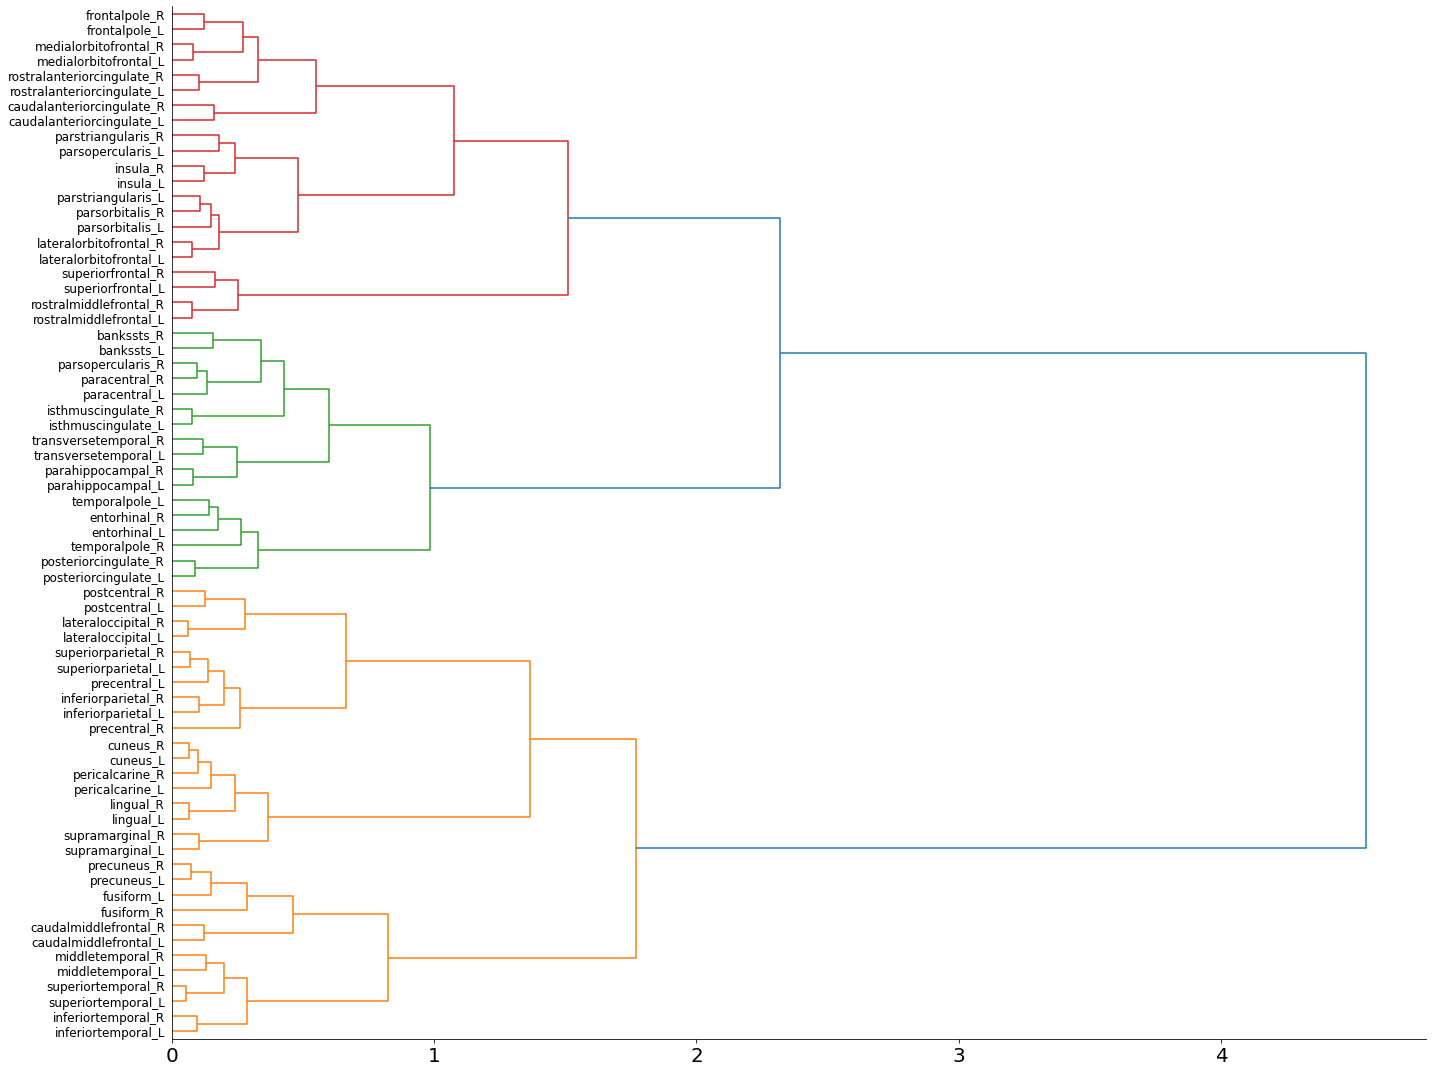

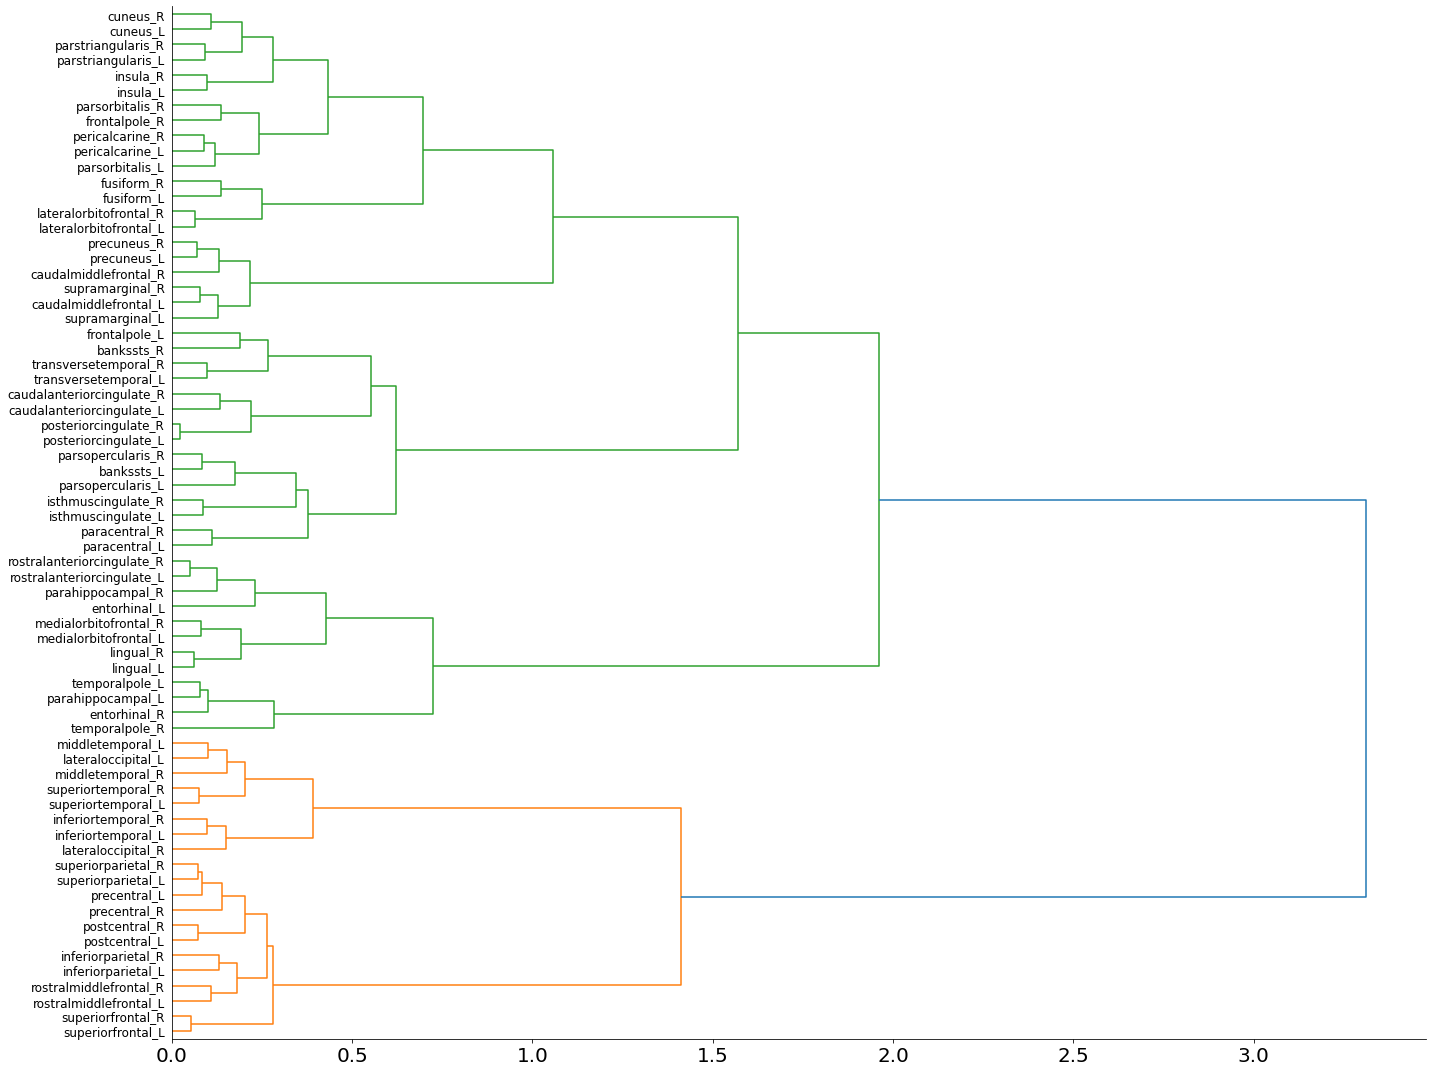

In [15]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 15 ))

clusters = shc.linkage(sim_pattern_roi_alpha, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters, orientation="right",color_threshold=2,
               leaf_rotation=0, leaf_font_size=12,
               labels=np.sort(region_names), ax=ax)
ax.tick_params(axis='x', labelsize=20)
ax.patch.set_alpha(1)
sns.despine()
plt.tight_layout()
#plt.savefig("dendongram_sim_pattern_alpha.png", dpi=300)


fig, ax = plt.subplots(figsize=(20,15 ))
clusters = shc.linkage(sim_pattern_roi_beta, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters, orientation="right",color_threshold=2,
               leaf_rotation=0, leaf_font_size=12,
               labels=np.sort(region_names), ax=ax)
ax.tick_params(axis='x', labelsize=20)
sns.despine()
plt.tight_layout()
#plt.savefig("dendongram_sim_pattern_beta.png", dpi=300, transparent=True)

fig, ax = plt.subplots(figsize=(20,15 ))
clusters = shc.linkage(sim_pattern_roi_theta, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters, orientation="right",color_threshold=2,
               leaf_rotation=0, leaf_font_size=12,
               labels=np.sort(region_names),  ax=ax)
ax.tick_params(axis='x', labelsize=20)
sns.despine()
plt.tight_layout()
#plt.savefig("dendongram_sim_pattern_theta.png", dpi=300)